<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Practicing loss functions and regression metrics

_Instructor: Aymeric Flaisler_

---


Below you will look at loss functions and at regression metrics related to these loss functions.

## 1. Load packages

In [10]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.regression.quantile_regression import QuantReg

import matplotlib as mpl
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline

/Users/aymericflaisler/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## 2. Plotting functions

Here are functions to make visualizing your regressions easier:

In [11]:
def plot_regression(x, y, model):
    plt.figure(figsize=(6,4))
    axes = plt.gca()
    
    intercept = model.params[0]
    slope = model.params[1]

    for x_, y_ in zip(x, y):    
        plt.plot((x_, x_), (y_, x_*slope + intercept),'k-', ls='dashed', lw=1)
        
    plt.scatter(x, y, s=70, c='steelblue')
    
    x_points = np.linspace(axes.get_xlim()[0], axes.get_xlim()[1], 100)
    
    regline_x = x_points
    regline_y = x_points*slope + intercept

    plt.plot(regline_x, regline_y, c='darkred', lw=3.5)

    plt.show()
    
def plot_residuals(model,loss='leastsquares'):
    
    resids = model.resid
    
    resid_lim = np.max([abs(np.min(resids)), abs(np.max(resids))]) + 1
    
    resid_points = np.linspace(-resid_lim, resid_lim, 200)
    
    plt.figure(figsize=(6,4))

    if loss == 'leastsquares':
        for r in resids:

            plt.plot((r, r), (0, r**2), 'k-', ls='dashed', lw=2)
        
        plt.plot(resid_points, resid_points**2, c='gold', alpha=0.7)
        plt.show()
        
    elif loss == 'lad':
        for r in resids:

            plt.plot((r, r), (0, np.abs(r)), 'k-', ls='dashed', lw=2)
        
        plt.plot(resid_points, np.abs(resid_points), c='green', alpha=0.7)
        plt.show()
    
    elif loss == 'both':
        for r in resids:
            
            plt.plot((r, r), (0, r**2), 'k-', ls='dashed', lw=2)
            plt.plot((r, r), (0, np.abs(r)), 'k-', ls='dashed', lw=2)
            
        plt.plot(resid_points, resid_points**2, c='gold', alpha=0.7)
        plt.plot(resid_points, np.abs(resid_points), c='green', alpha=0.7)
        plt.show()
    
    else:
        print('Options are leastsquares or lad.')

## 3. Load the autostats dataset

In [12]:
df = pd.read_csv('./datasets/Auto.csv')

In [13]:
df.shape

(397, 9)

In [14]:
df.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
0,18.0,8,307.0,130,3504,12.0,70,1,chevrolet chevelle malibu
1,15.0,8,350.0,165,3693,11.5,70,1,buick skylark 320
2,18.0,8,318.0,150,3436,11.0,70,1,plymouth satellite
3,16.0,8,304.0,150,3433,12.0,70,1,amc rebel sst
4,17.0,8,302.0,140,3449,10.5,70,1,ford torino


## 4. Choose a continuous response variable and predictor variable from the dataset

You might have to clean the data.

In [15]:
X = df['horsepower'].values
y = df['mpg'].values

In [16]:
X.dtype

dtype('O')

In [17]:
def trafo(x):
    try:
        x = float(x)
    except:
        x = np.nan
    return x

In [18]:
X = np.array([trafo(x) for x in X])

In [19]:
y_nonan = y[~np.isnan(X)]
X_nonan = X[~np.isnan(X)]
print(y_nonan.shape)
print(X_nonan.shape)

(392,)
(392,)


## 5. Build a least squares regression model predicting your response from your predictors

Hint: use the code from the lesson

In [20]:
leastsq_reg = sm.OLS(y_nonan, sm.add_constant(X_nonan)).fit()
leastsq_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.606
Model:                            OLS   Adj. R-squared:                  0.605
Method:                 Least Squares   F-statistic:                     599.7
Date:                Wed, 11 Jul 2018   Prob (F-statistic):           7.03e-81
Time:                        12:58:04   Log-Likelihood:                -1178.7
No. Observations:                 392   AIC:                             2361.
Df Residuals:                     390   BIC:                             2369.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         39.9359      0.717     55.660      0.000      38.525      41.347
x1            -0.1578      0.006    -24.489      0.000      -0.171      -0.145
==============================================================================
Omnibus:                       16.432   Durbin-Watson:                   0.920
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               17.305
Skew:                           0.492   Prob(JB):                     0.000175
Kurtosis:                       3.299   Cond. No.                         322.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 6. Plot the least squares regression

You can use the ```plot_regression(x, y, model)``` function provided.

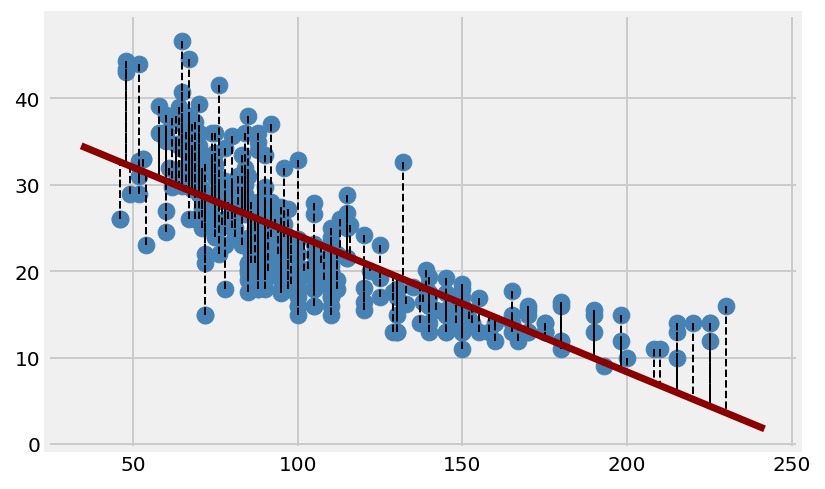

In [21]:
plot_regression(X_nonan, y_nonan, leastsq_reg)

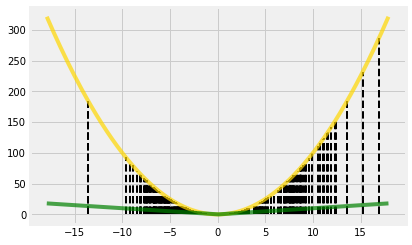

In [13]:
plot_residuals(leastsq_reg,'both')

## 7. Build a least absolute deviation quantreg model on the same sample

In [14]:
lad_reg = QuantReg(y_nonan, sm.add_constant(X_nonan)).fit(q=0.5)
lad_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      y   Pseudo R-squared:               0.4164
Model:                       QuantReg   Bandwidth:                       2.983
Method:                 Least Squares   Sparsity:                        11.54
Date:                Fri, 09 Mar 2018   No. Observations:                  392
Time:                        12:10:24   Df Residuals:                      390
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         40.4193      0.844     47.907      0.000      38.761      42.078
x1            -0.1645      0.008    -21.706      0.000      -0.179      -0.150
==============================================================================
"""

## 8. Plot the LAD regression

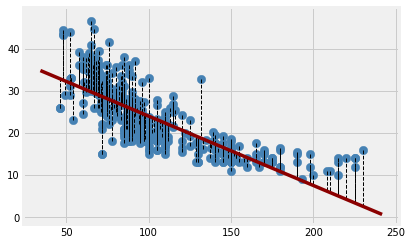

In [15]:
plot_regression(X_nonan, y_nonan, lad_reg)

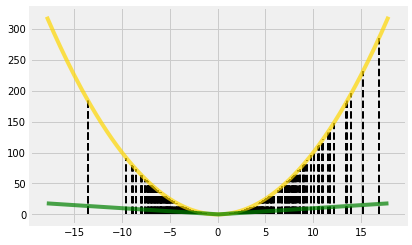

In [16]:
plot_residuals(lad_reg,'both')

## 9. Calculate the RMSE and the MAE between your response and the predicted response

**RMSE** is the **root mean squared error**. It is a metric for the performance of your regression related to the least squared loss. 

$$\text{RMSE} = \sqrt{\frac{\sum_{i}{\left(\hat{y}_i - y_i \right)^2}}{n}}$$

https://en.wikipedia.org/wiki/Root-mean-square_deviation

**MAE** is the **mean absolute error**. It is a metric for regression performace when the loss function is the least absolute deviation.

$$\text{MAE} = \frac{\sum_{i}{|\hat{y}_i - y_i |}}{n}$$

https://en.wikipedia.org/wiki/Average_absolute_deviation

In [17]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [18]:
leastsq_predictions = leastsq_reg.predict()
lad_predictions = lad_reg.predict()

print(np.sqrt(mean_squared_error(y_nonan, leastsq_predictions)))

print(mean_absolute_error(y_nonan, lad_predictions))

4.893226230065713
3.8075049385128414


## 10. [BONUS] Create a quantile regression with q = 0.25 and plot it. What exactly is this regression predicting?

In [24]:
q25_reg = QuantReg(y_nonan, sm.add_constant(X_nonan)).fit(q=0.9)
q25_reg.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                         QuantReg Regression Results                          
==============================================================================
Dep. Variable:                      y   Pseudo R-squared:               0.3365
Model:                       QuantReg   Bandwidth:                       2.542
Method:                 Least Squares   Sparsity:                        40.32
Date:                Wed, 11 Jul 2018   No. Observations:                  392
Time:                        13:06:12   Df Residuals:                      390
                                        Df Model:                            1
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         48.1200      2.611     18.427      0.000      42.986      53.254
x1            -0.1680      0.024     -6.928      0.000      -0.216      -0.120
==============================================================================
"""

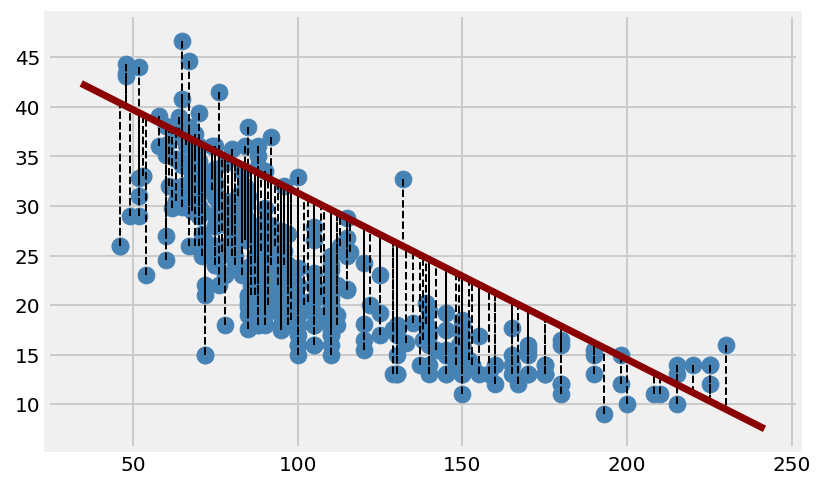

In [25]:
plot_regression(X_nonan, y_nonan, q25_reg)

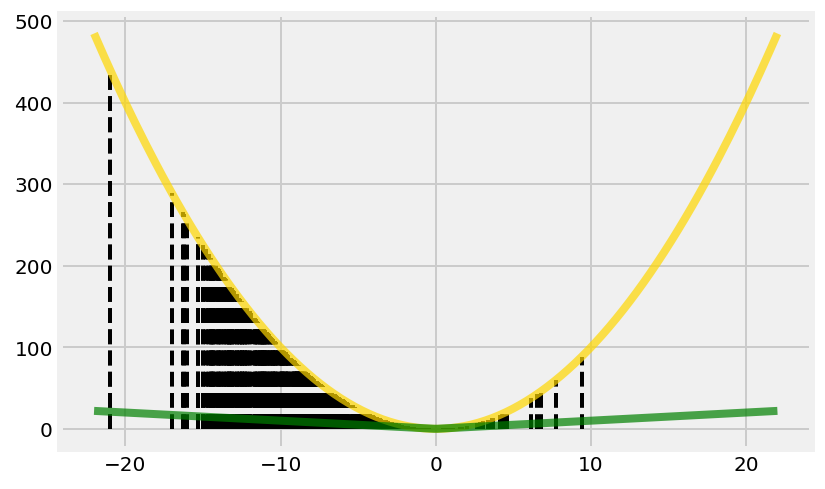

In [26]:
plot_residuals(q25_reg,'both')

When q=0.25, the quantile regression is **predicting the 25th percentile of the response variable given the predictors**.

In [22]:
leastsq_reg.params

array([39.93586102, -0.15784473])

In [23]:
lad_reg.params

array([40.41934529, -0.16451603])

In [24]:
q25_reg.params

array([33.41175371, -0.12941169])